# VinBigData detectron2 prediction


**Following from the training kernel [VinBigData detectron2 train](https://www.kaggle.com/corochann/vinbigdata-detectron2-train), I will try prediction with the `detectron2` trained model**

`detectron2` is one of the famous pytorch object detection library, I will introduce how to use this library to predict bounding boxes with the trained model.

 - https://github.com/facebookresearch/detectron2

> Detectron2 is Facebook AI Research's next generation software system that implements state-of-the-art object detection algorithms. It is a ground-up rewrite of the previous version, Detectron, and it originates from maskrcnn-benchmark.
![](https://user-images.githubusercontent.com/1381301/66535560-d3422200-eace-11e9-9123-5535d469db19.png)


## Version history

2021/1/22: Update to add 2-class filter in troduced in [VinBigData 🌟2 Class Filter🌟](https://www.kaggle.com/awsaf49/vinbigdata-2-class-filter) by @awsaf49 <br/>
I also wrote kernel to train 2-class model: [📸VinBigData 2-class classifier complete pipeline](https://www.kaggle.com/corochann/vinbigdata-2-class-classifier-complete-pipeline)

# Table of Contents

** [Prediction method implementations](#pred_method)** <br/>
** [Prediction scripts](#pred_scripts)** <br/>
** [Apply 2 class filter](#2class)** <br/>
** [Other kernels](#ref)** <br/>

Since first setup part is same with the training kernel, I skipped listing on ToC.

# Dataset preparation

Preprocessing x-ray image format (dicom) into normal png image format is already done by @xhlulu in the below discussion:
 - [Multiple preprocessed datasets: 256/512/1024px, PNG and JPG, modified and original ratio](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/207955).

Here I will just use the dataset [VinBigData Chest X-ray Resized PNG (256x256)](https://www.kaggle.com/xhlulu/vinbigdata-chest-xray-resized-png-256x256) to skip the preprocessing and focus on modeling part. Please upvote the dataset as well!

In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)


# Installation

detectron2 is not pre-installed in this kaggle docker, so let's install it. 
We can follow [installation instruction](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md), we need to know CUDA and pytorch version to install correct `detectron2`.

In [2]:
!nvidia-smi

Sat Jan 30 16:45:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:24:38_PDT_2019
Cuda compilation tools, release 10.2, V10.2.89


In [4]:
import torch

torch.__version__

'1.7.0'

It seems CUDA=10.2 and torch==1.7.0 is used in this kaggle docker image.

See [installation](https://detectron2.readthedocs.io/tutorials/install.html) for details.

In [5]:
!pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html
     |████████████████████████████████| 6.8 MB 646 kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20210128-py3-none-any.whl size=41551 sha256=49b20beb40f4e1aa5198ea2665e4f28f83dc0f00e942ca32d80636a4b0170e0e
  Stored in directory: /root/.cache/pip/wheels/b4/44/0f/a73b9c37698c8bdbc859a9088fb808cc8727aeb4d07cc1b5cf
  Created wheel for iopath: filename=iopath-0.1.3-py3-none-any.whl size=11169 sha256=a526e86ccd8449028cbdf56e4fd1afe12569d82d84bfec22a44465f8082500be
  Stored in directory: /root/.cache/pip/wheels/33/44/20/06445612ad8cf4ad6250aee85516e9499d5a49151ef5358164
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=273766 sha256=c848f92c0c6d18ef2538e9f1f4f94d3a786fc172d176feffd7e7f6f3be354241
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built fvcore iopath pycocotools

<a id="pred_method"></a>
# Prediction method implementations

Basically we don't need to implement neural network part, `detectron2` already implements famous architectures and provides its pre-trained weights. We can finetune these pre-trained architectures.

These models are summarized in [MODEL_ZOO.md](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

In this competition, we need object detection model, I will choose [R50-FPN](https://github.com/facebookresearch/detectron2/blob/master/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml) for this kernel.

## Data preparation

`detectron2` provides high-level API for training custom dataset.

To define custom dataset, we need to create **list of dict** where each dict contains following:

 - file_name: file name of the image.
 - image_id: id of the image, index is used here.
 - height: height of the image.
 - width: width of the image.
 - annotation: This is the ground truth annotation data for object detection, which contains following
     - bbox: bounding box pixel location with shape (n_boxes, 4)
     - bbox_mode: `BoxMode.XYXY_ABS` is used here, meaning that absolute value of (xmin, ymin, xmax, ymax) annotation is used in the `bbox`.
     - category_id: class label id for each bounding box, with shape (n_boxes,)

`get_vinbigdata_dicts` is for train dataset preparation and `get_vinbigdata_dicts_test` is for test dataset preparation.

In [6]:
import pickle
from pathlib import Path

import cv2
import pandas as pd
from detectron2.structures import BoxMode
from tqdm import tqdm


def get_vinbigdata_dicts(
    imgdir: Path, train: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        train_meta = pd.read_csv(imgdir / "train_meta.csv")
        if debug:
            train_meta = train_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = train_meta.loc[0, "image_id"]
        image_path = str(imgdir / "train" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):
            record = {}

            image_id, height, width = train_meta_row.values
            filename = str(imgdir / "train" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = index
            record["height"] = resized_height
            record["width"] = resized_width
            objs = []
            for index2, row in train.query("image_id == @image_id").iterrows():
                # print(row)
                # print(row["class_name"])
                # class_name = row["class_name"]
                class_id = row["class_id"]
                if class_id == 14:
                    # It is "No finding"
                    # This annotator does not find anything, skip.
                    pass
                else:
                    # bbox_original = [int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])]
                    h_ratio = resized_height / height
                    w_ratio = resized_width / width
                    bbox_resized = [
                        int(row["x_min"]) * w_ratio,
                        int(row["y_min"]) * h_ratio,
                        int(row["x_max"]) * w_ratio,
                        int(row["y_max"]) * h_ratio,
                    ]
                    obj = {
                        "bbox": bbox_resized,
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": class_id,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts


def get_vinbigdata_dicts_test(
    imgdir: Path, test_meta: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache_test{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        # test_meta = pd.read_csv(imgdir / "test_meta.csv")
        if debug:
            test_meta = test_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = test_meta.loc[0, "image_id"]
        image_path = str(imgdir / "test" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}

            image_id, height, width = test_meta_row.values
            filename = str(imgdir / "test" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = index
            record["height"] = resized_height
            record["width"] = resized_width
            # objs = []
            # record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts


Methods for prediction for this competition

In [7]:
# Methods for prediction for this competition
from math import ceil
from typing import Any, Dict, List

import cv2
import detectron2
import numpy as np
from numpy import ndarray
import pandas as pd
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode, Visualizer
from tqdm import tqdm


def format_pred(labels: ndarray, boxes: ndarray, scores: ndarray) -> str:
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.int64)
        pred_strings.append(f"{label} {score} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)


def predict_batch(predictor: DefaultPredictor, im_list: List[ndarray]) -> List:
    with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
        inputs_list = []
        for original_image in im_list:
            # Apply pre-processing to image.
            if predictor.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            image = predictor.aug.get_transform(original_image).apply_image(original_image)
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
            inputs = {"image": image, "height": height, "width": width}
            inputs_list.append(inputs)
        predictions = predictor.model(inputs_list)
        return predictions


In [8]:
# --- utils ---
from pathlib import Path
from typing import Any, Union

import yaml


def save_yaml(filepath: Union[str, Path], content: Any, width: int = 120):
    with open(filepath, "w") as f:
        yaml.dump(content, f, width=width)


def load_yaml(filepath: Union[str, Path]) -> Any:
    with open(filepath, "r") as f:
        content = yaml.full_load(f)
    return content


In [9]:
# --- configs ---
thing_classes = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]
category_name_to_id = {class_name: index for index, class_name in enumerate(thing_classes)}


This `Flags` class is to manage experiments. I will tune these parameters through the competition to improve model's performance.

In [10]:
# --- flags ---
from dataclasses import dataclass
from typing import Dict


@dataclass
class Flags:
    # General
    debug: bool = True
    outdir: str = "results/det"

    # Data config
#     imgdir_name: str = "vinbigdata-chest-xray-resized-png-256x256"
    imgdir_name: str = "vinbigdata"
    # Training config
    iter: int = 10000
    ims_per_batch: int = 2  # images per batch, this corresponds to "total batch size"
    num_workers: int = 4
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512

    def update(self, param_dict: Dict) -> "Flags":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self


<a id="pred_scripts"></a>
# Prediction scripts

Now the methods are ready. Main training scripts starts from here.

In [11]:
flags_dict = {
#     "debug": True,
    "debug": False,
#     "outdir": "results/debug",
    "outdir": "results",
#     "imgdir_name": "vinbigdata-chest-xray-resized-png-256x256",
    "imgdir_name": "vinbigdata",
    "iter": 100,  # debug, small value should be set.
    "roi_batch_size_per_image": 128  # faster, and good enough for this toy dataset (default: 512)
}

flags Flags(debug=False, outdir='results', imgdir_name='vinbigdata', iter=100, ims_per_batch=2, num_workers=4, base_lr=0.00025, roi_batch_size_per_image=128)
cfg.OUTPUT_DIR ./output -> results
Original thresh 0.05
Changed  thresh 0.0


 36%|███▌      | 1074/3000 [00:00<00:00, 10738.37it/s]

Creating data...
image shape: (512, 512, 3)


  0%|          | 0/750 [00:00<?, ?it/s]

Load from cache dataset_dicts_cache_test_debug0.pkl


/opt/conda/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning:

This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/torch/csrc/utils/python_arg_parser.cpp:882.)

100%|██████████| 750/750 [04:55<00:00,  2.54it/s]


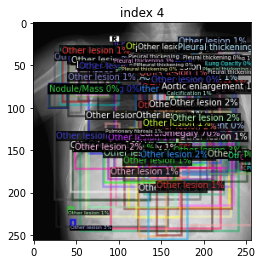

In [12]:
inputdir = Path("/kaggle/input")
# traineddir = inputdir / "vinbigdata-r50fpn3x-512px"
traineddir = inputdir / "fork-2-vinbigdata-detectron2-train"

# flags = Flags()
# flags: Flags = Flags().update(load_yaml(str(traineddir/"flags.yaml")))
flags: Flags = Flags().update(flags_dict)
print("flags", flags)
debug = flags.debug
# flags_dict = dataclasses.asdict(flags)
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)

# --- Read data ---
datadir = inputdir / "vinbigdata-chest-xray-abnormalities-detection"
imgdir = inputdir / flags.imgdir_name

# Read in the data CSV files
# train = pd.read_csv(datadir / "train.csv")
test_meta = pd.read_csv(inputdir / "vinbigdata-testmeta" / "test_meta.csv")
sample_submission = pd.read_csv(datadir / "sample_submission.csv")

cfg = get_cfg()
original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = str(outdir)
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("vinbigdata_train",)
cfg.DATASETS.TEST = ()
# cfg.DATASETS.TEST = ("vinbigdata_train",)
# cfg.TEST.EVAL_PERIOD = 50
cfg.DATALOADER.NUM_WORKERS = 2
# Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

### --- Inference & Evaluation ---
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
# path to the model we just trained
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.WEIGHTS = str(traineddir / "model_final.pth")
cfg.MODEL.WEIGHTS = str(traineddir / "results/v9/model_0029999.pth")
print("Original thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)  # 0.05
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0   # set a custom testing threshold
print("Changed  thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)  # 0.0
predictor = DefaultPredictor(cfg)

DatasetCatalog.register(
    "vinbigdata_test", lambda: get_vinbigdata_dicts_test(imgdir, test_meta, debug=debug)
)
MetadataCatalog.get("vinbigdata_test").set(thing_classes=thing_classes)
metadata = MetadataCatalog.get("vinbigdata_test")
dataset_dicts = get_vinbigdata_dicts_test(imgdir, test_meta, debug=debug)

if debug:
    dataset_dicts = dataset_dicts[:100]

results_list = []
index = 0
batch_size = 4

for i in tqdm(range(ceil(len(dataset_dicts) / batch_size))):
    inds = list(range(batch_size * i, min(batch_size * (i + 1), len(dataset_dicts))))
    dataset_dicts_batch = [dataset_dicts[i] for i in inds]
    im_list = [cv2.imread(d["file_name"]) for d in dataset_dicts_batch]
    outputs_list = predict_batch(predictor, im_list)

    for im, outputs, d in zip(im_list, outputs_list, dataset_dicts_batch):
        resized_height, resized_width, ch = im.shape
        # outputs = predictor(im)
        if index < 5:
            # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
            v = Visualizer(
                im[:, :, ::-1],
                metadata=metadata,
                scale=0.5,
                instance_mode=ColorMode.IMAGE_BW
                # remove the colors of unsegmented pixels. This option is only available for segmentation models
            )
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            cv2.imwrite(str(outdir / f"pred_{index}.jpg"), out.get_image()[:, :, ::-1])
            plt.title(f"index {index}")
            plt.imshow(out.get_image()[:, :, ::-1])

        assert d["image_id"] == index
        image_id, dim0, dim1 = test_meta.iloc[index].values

        instances = outputs["instances"]
        if len(instances) == 0:
            # No finding, let's set 14 0 0 0 0.
            result = {"image_id": image_id, "PredictionString": "14 1.0 0 0 1 1"}
        else:
            # Find some bbox...
            # print(f"index={index}, find {len(instances)} bbox.")
            fields: Dict[str, Any] = instances.get_fields()
            pred_classes = fields["pred_classes"]  # (n_boxes,)
            pred_scores = fields["scores"]
            # shape (n_boxes, 4). (xmin, ymin, xmax, ymax)
            pred_boxes = fields["pred_boxes"].tensor

            h_ratio = dim0 / resized_height
            w_ratio = dim1 / resized_width
            pred_boxes[:, [0, 2]] *= w_ratio
            pred_boxes[:, [1, 3]] *= h_ratio

            pred_classes_array = pred_classes.cpu().numpy()
            pred_boxes_array = pred_boxes.cpu().numpy()
            pred_scores_array = pred_scores.cpu().numpy()

            result = {
                "image_id": image_id,
                "PredictionString": format_pred(
                    pred_classes_array, pred_boxes_array, pred_scores_array
                ),
            }
        results_list.append(result)
        index += 1

Here I set `cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0` to produce **all the detection box prediction even if confidence score is very low**.<br/>
Actually it affects a lot to score, since competition metric is AP (Average-Precision) which is calculated using the boxes with confidence score = 0~100%.

In [13]:
# This submission includes only detection model's predictions
submission_det = pd.DataFrame(results_list, columns=['image_id', 'PredictionString'])
submission_det.to_csv(outdir/"submission_det.csv", index=False)
submission_det

,image_id,PredictionString
0,8dec5497ecc246766acfba5a4be4e619,0 0.8438339233398438 1043 603 1247 873 3 0.605...
1,287422bed1d9d153387361889619abed,3 0.9829716086387634 635 970 1885 1978 0 0.736...
2,1d12b94b7acbeadef7d7700b50aa90d4,3 0.9114925265312195 822 1545 1927 2112 0 0.59...
3,6b872791e23742f6c33a08fc24f77365,9 0.3895277678966522 1556 1986 1864 2297 11 0....
4,d0d2addff91ad7beb1d92126ff74d621,0 0.887931227684021 1419 820 1704 1191 3 0.698...
...,...,...
2995,78b44b96b121d6075d7ae27135278e03,0 0.45998385548591614 1040 765 1216 959 11 0.2...
2996,afee8ff90f29b8827d0eb78774d25324,0 0.6509377360343933 1048 716 1242 957 3 0.186...
2997,6e07fab2014be723250f7897ab6e3df2,0 0.9841672778129578 1665 787 2002 1158 3 0.94...
2998,690bb572300ef08bbbb7ebf4196099cf,9 0.40054580569267273 819 867 1460 2074 9 0.34...


<a id="2class"></a>
# Apply 2 class filter

As mentioned in [VinBigData 🌟2 Class Filter🌟](https://www.kaggle.com/awsaf49/vinbigdata-2-class-filter) by @awsaf49, applying 2-class filter improves LB score significantly. (Please upvote his kernel as well!)<br/>
Also, it is mentioned that we can submit **14 prob 1 1 0 0** where the `prob` is the normal probability in the discussion [[Scoring bug] Improve your LB score by 0.053, just adding "14 1 0 0 1 1"](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/211971)!

Here, I will propose new post processing (similar to [this](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/211971#1157809) by @pestipeti):

Here `p` is the **normal probability**.

1. `p < low_threshold`                   -> Do nothing, Keep det prediction.
2. `low_threshold <= p < high_threshold` -> Just "Add" Normal prediction, **keep** detection prediction.
3. `high_threshold <= p`                 -> Replace with Normal prediction with normal score 1.0, **remove** all detection predictoin.


[Note] I also wrote another kernel to train 2-class model: [📸VinBigData 2-class classifier complete pipeline](https://www.kaggle.com/corochann/vinbigdata-2-class-classifier-complete-pipeline) to train these 2-class classifier model!

In [14]:
pred_2class = pd.read_csv(inputdir/"vinbigdata-2class-prediction/2-cls test pred.csv")
pred_2class

,image_id,target
0,002a34c58c5b758217ed1f584ccbcfe9,0.013326
1,004f33259ee4aef671c2b95d54e4be68,0.037235
2,008bdde2af2462e86fd373a445d0f4cd,0.939700
3,009bc039326338823ca3aa84381f17f1,0.123799
4,00a2145de1886cb9eb88869c85d74080,0.654006
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,0.936325
2996,ff9fcc4087ed5e941209aa3fa948e364,0.963583
2997,ffaa288c8abca300974f043b57d81521,0.178720
2998,ffc441e0c8b7153844047483a577e7c3,0.225196


In [15]:
NORMAL = "14 1 0 0 1 1"
low_threshold = 0.0
high_threshold = 0.95

pred_det_df = submission_det  # You can load from another submission.csv here too.
n_normal_before = len(pred_det_df.query("PredictionString == @NORMAL"))
merged_df = pd.merge(pred_det_df, pred_2class, on="image_id", how="left")

# 1. p < low_threshold                   -> "Keep": Do nothing, Keep det prediction.
# 2. low_threshold <= p < high_threshold -> "Add": Just "Add" Normal prediction
# 3. high_threshold <= p                 -> "Replace": Replace with Normal prediction

if "target" in merged_df.columns:
    merged_df["class0"] = 1 - merged_df["target"]

c0, c1, c2 = 0, 0, 0
for i in range(len(merged_df)):
    p0 = merged_df.loc[i, "class0"]
    if p0 < low_threshold:
        # Keep, do nothing.
        c0 += 1
    elif low_threshold <= p0 and p0 < high_threshold:
        # Add, keep "det" preds and add normal pred.
        merged_df.loc[i, "PredictionString"] += f" 14 {p0} 0 0 1 1"
        c1 += 1
    else:
        # Replace, remove all "det" preds.
        merged_df.loc[i, "PredictionString"] = NORMAL
        c2 += 1

n_normal_after = len(merged_df.query("PredictionString == @NORMAL"))
print(
    f"n_normal: {n_normal_before} -> {n_normal_after} with threshold {low_threshold} & {high_threshold}"
)
print(f"Keep {c0} Add {c1} Replace {c2}")
submission_filepath = str(outdir / "submission.csv")
submission_df = merged_df[["image_id", "PredictionString"]]
submission_df.to_csv(submission_filepath, index=False)
print(f"Saved to {submission_filepath}")

n_normal: 0 -> 1700 with threshold 0.0 & 0.95
Keep 0 Add 1300 Replace 1700
Saved to results/submission.csv


In my experiment:
 - The baseline submission: score 0.141
 - Just replace by threshold ([version3](https://www.kaggle.com/corochann/vinbigdata-detectron2-prediction?scriptVersionId=52412540) ): score 0.206
 - This post process (combine replace & add): **0.221**

So the score improved by about **0.8, which is significant**!

In more detail, I tried to change several `low_threshold` value and lower `low_threshold` achieved better results. So it may be okay to set `low_threshold=0.0` which means **always add "No finding" prediction with the predicted probability.**<br/>
I also noticed that setting `high_threshold` value less than 1 is important, which means we have a benefit to **remove abnormality predictions** for the images which is highly likely to be normal.<br/>
This may be because my [training kernel](https://www.kaggle.com/corochann/vinbigdata-detectron2-train) currently only uses abnormal image during training and model tend to produce more abnormal boxes. I'm now thinking that it's better to include normal images for training to learn where there is **no** abnormality.<br/>
Also, I think it's nice to try **including "No finding" class during detection training** (by adding virtual "No finding" boxes, or by adding global classifier together with the detection).


That's all!
Object deteaction is rather complicated task among deep learning tasks, but it's easy to train SoTA models & predict using `detectron2`!!!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated 😁<br>Thanks!</h3>

<a id="ref"></a>
# Other kernels

[📸VinBigData detectron2 train](https://www.kaggle.com/corochann/vinbigdata-detectron2-train) kernel explains how to run object detection training, using `detectron2` library.

[📸VinBigData 2-class classifier complete pipeline](https://www.kaggle.com/corochann/vinbigdata-2-class-classifier-complete-pipeline) kernel explains how to train 2 class classifier model for the prediction and submisssion for this competition.